In [1]:
# import pandas as pd
# import numpy as np
# #import random

# from sklearn.model_selection import train_test_split
# from sklearn import preprocessing
# from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader

# from einops import rearrange

# from time import sleep
# import sys

In [2]:
from collections import Counter
from collections import defaultdict

#import json

from einops import rearrange
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import torch.nn.functional as F

import math
import random
import time
import sys
import glob
import re

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Helpers

## functions

In [4]:
def create_char_dict():
    i = 0
    char_to_num = {}
    num_to_char = {}
    for c in range(48,58):
        i += 1
        num = (i + 4) / 44
        char = chr(c)
        char_to_num[char] = num
        num_to_char[num] = char
    for c in range(97, 123):
        i += 1
        num = (i + 4) / 44
        char = chr(c)
        char_to_num[char] = num
        num_to_char[i] = char
    return char_to_num, num_to_char

def nums_to_word(word, num_to_char):
    word_out = ''
    for w in word:
        letter = round(w * 44 - 4)
        word_out += num_to_char.get(letter, '')
    return word_out

In [5]:
def remove_punc(line):
    pattern = re.compile('[^a-zA-Z0-9 ]+') 
    no_punct = pattern.sub('', line.strip())
    return no_punct.lower()

def get_data_from_file(file_name, word_length, char_to_num):
    words = []
    with open(file_name, 'r') as f:
        for line in f:
            l = remove_punc(line)
            words.extend(l.split())
    data = []
    it = iter(words)
    while True:
        try:
            word = next(it)
        except StopIteration:
            break
        w = torch.zeros(word_length)
        for i, char in enumerate(word[:word_length]):
            w[i] = char_to_num[char]
        data.append(w)
    return torch.stack(data)

def get_data_from_line(line, word_length, char_to_num):
    words = remove_punc(line).split()
    data = []
    it = iter(words)
    while True:
        try:
            word = next(it)
        except StopIteration:
            break
        w = torch.zeros(word_length)
        for i, char in enumerate(word[:word_length]):
            w[i] = char_to_num[char]
        data.append(w)
    return torch.stack(data)

def data_to_line(line, num_to_char):
    line_out = ''
    for word in line:
        word_out = nums_to_word(word, num_to_char)
        line_out = line_out + word_out + ' '
    return line_out

In [6]:
def set_dropout(model, drop_rate):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
        set_dropout(child, drop_rate = drop_rate)

In [7]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.show()

# Models

## embedding

In [8]:
class Conv1d_layer(nn.Module):
    def __init__(self, ch_in, ch_out, word_length, ker = 3, padding = 1):
        super().__init__()
        self.conv = nn.Conv1d(ch_in, ch_out, ker, padding = padding)
        self.ln = nn.LayerNorm(word_length)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.ln(x)
        x = F.relu(x)
        return x

In [9]:
class Embedder(nn.Module):
    def __init__(self, word_length, emb_layers, d_emb, emb_drop, seq_length):
        super().__init__()
        
        net = []
        for i in range(len(emb_layers) - 1):
            net.append(Conv1d_layer(emb_layers[i], emb_layers[i + 1], word_length))
        self.net = nn.Sequential(*net)
        self.net.apply(self.init_weights)
        
        self.out = nn.Linear(word_length * emb_layers[-1], d_emb)   
        
        self.d_emb = d_emb
        self.sr_d_emb = np.sqrt(d_emb)
        self.dropout = nn.Dropout(emb_drop)
        self.seq_length = seq_length
        self.pos_encode()
        
    def init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def pos_encode(self):
        self.pe = torch.zeros(self.seq_length, self.d_emb)
        pos = torch.arange(0, self.seq_length)
        ii = torch.arange(0, self.d_emb, 2)
        div_term = torch.exp(ii * -np.log(10000) / self.d_emb)
        matrix = torch.einsum('i,j->ij', pos, div_term)
        self.pe[:, 0::2] = torch.sin(matrix)
        self.pe[:, 1::2] = torch.cos(matrix)
        self.pe = self.pe.unsqueeze(0)
        self.pe = self.pe.to(device)
    
    def forward(self, x):
        seq = x.size(1)
        x = rearrange(x, 'b s (i j) -> (b s) i j', i = 1)
        # x = self.conv1(x)
        # x = self.ln1(x)
        # x = F.relu(x)
        # x = self.conv2(x)
        # x = self.ln2(x)
        # x = F.relu(x)
        # x = self.conv3(x)
        x = self.net(x)
        #x = rearrange(x, '(b s) i j -> b s (i j)', s = self.seq_length)
        x = rearrange(x, '(b s) i j -> b s (i j)', s = seq)
        x = self.out(x)
        
        # make embeddings relatively larger
        x = x * self.sr_d_emb
        #add constant to embedding
        x = x + self.pe[:, :x.size(1)]
        x = self.dropout(x)
        return x

## transformer blocks

### Multi Head Attention

In [10]:
# def create_masks(question, reply_input, reply_target):
    
#     def subsequent_mask(size):
#         mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
#         return mask.unsqueeze(0)
    
#     question_mask = question!=0
#     question_mask = question_mask.to(device)
#     question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
#     reply_input_mask = reply_input!=0
#     reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
#     reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
#     reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
#     reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
#     return question_mask, reply_input_mask, reply_target_mask

In [11]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, hidden_dim, heads, decode = False, mask = False):
        super().__init__()
        self.h_dim = hidden_dim
        self.heads = heads
        self.dim_per_head = self.h_dim // self.heads
        self.decode = decode
        self.mask = mask
        if self.decode:
            self.q = nn.Linear(d_emb, self.h_dim, bias = False)
            self.kv = nn.Linear(d_emb, self.h_dim * 2, bias = False)
        else:
            self.qkv = nn.Linear(d_emb, self.h_dim * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.h_dim, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        if self.mask:
            d = scores.size(-1)
            inds = torch.triu_indices(d, d, offset = 1)
            scores[..., inds[0], inds[1]] = -float('inf')
        #scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x, y = None):
        if self.decode:
            q = self.q(y)
            kv = self.kv(x)
            k = kv[..., :self.h_dim]
            v = kv[..., self.h_dim:]
        else:
            qkv = self.qkv(x)
            q = qkv[..., :self.h_dim]
            k = qkv[..., self.h_dim:self.h_dim * 2]
            v = qkv[..., self.h_dim * 2:]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
        
        # dims = *scores.size()[:-2], self.h_dim
        # scores = torch.einsum('ijkl->ikjl').contiguous().view(dims)
        
        return self.unifyheads(scores)

### Encoder

In [12]:
class Encoder_layer(nn.Module):
    def __init__(self, enc_drop, hidden_mult, d_emb, hidden_dim, heads):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, hidden_dim, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            nn.ReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [13]:
class Encoder(nn.Module):
    def __init__(self, enc_drop, hidden_mult, d_emb, hidden_dim, heads_order):
        super().__init__()
        layers = []
        for heads in heads_order:
            layers.append(Encoder_layer(enc_drop, hidden_mult, d_emb, hidden_dim, heads))
        self.layers = nn.Sequential(*layers)
                
    def forward(self, x):
        x = self.layers(x)
        return x

### Decoder

In [14]:
class Decoder_layer(nn.Module):
    def __init__(self, dec_drop, hidden_mult, d_emb, hidden_dim, heads):
        super().__init__()
        self.dropout = nn.Dropout(dec_drop)
        
        self.mha_1 = Multi_Head_Attention(d_emb, hidden_dim, heads, mask = True)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.mha_2 = Multi_Head_Attention(d_emb, hidden_dim, heads, decode = True)
        self.norm_2 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            nn.ReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        self.norm_3 = nn.LayerNorm(d_emb)
        
    def forward(self, x, y):
        attended = self.mha_1(y)
        y = attended + y
        y = self.dropout(y)
        y = self.norm_1(y)
        attended = self.mha_2(x, y)
        y = attended + y
        y = self.dropout(y)
        y = self.norm_2(y)
        fed_for = self.ff(y)
        y = fed_for + y
        y = self.dropout(y)
        y = self.norm_3(y)
        return y

In [15]:
class Decoder(nn.Module):
    def __init__(self, dec_drop, hidden_mult, d_emb, hidden_dim, heads_order):
        super().__init__()
        layers = []
        for heads in heads_order:
            layers.append(Decoder_layer(dec_drop, hidden_mult, d_emb, hidden_dim, heads))
        self.layers = nn.Sequential(*layers)
                
    def forward(self, x, y):
        y = self.layers(x, y)
        return y

## Transformer

In [16]:
# new
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        dropouts, hidden_mult, hidden_dim, heads_order, d_emb, word_length, seq_length, emb_layers = model_hp
        emb_drop, enc_drop, dec_drop = dropouts
        
        self.embedder = Embedder(word_length, emb_layers, d_emb, emb_drop, seq_length)
        self.encoder = nn.ModuleList([Encoder_layer(enc_drop, hidden_mult, d_emb, 
                                                    hidden_dim, heads) for heads in heads_order])
        self.decoder = nn.ModuleList([Decoder_layer(dec_drop, hidden_mult, d_emb, 
                                                    hidden_dim, heads) for heads in heads_order])
        self.out = nn.Sequential(
            nn.Linear(d_emb, d_emb * 2),
            nn.ReLU(),
            nn.Linear(d_emb * 2, d_emb),
            nn.ReLU(),
            nn.Linear(d_emb, word_length),
            nn.Sigmoid())
        
    def encode(self, x):
        x = self.embedder(x)
        for enc in self.encoder:
            x = enc(x)
        return x
    
    def decode(self, x, y):
        y = self.embedder(y)
        for dec in self.decoder:
            y = dec(x, y)
        return y
    
    def forward(self, x, y):
        encoded = self.encode(x)
        decoded = self.decode(encoded, y)
        out = self.out(decoded)
        return out

In [17]:
class BERT_block(nn.Module):
    def __init__(self, dropout, hidden_mult, d_emb, hidden_dim, heads):
        super().__init__()
        self.encoder = Encoder_layer(dropout, hidden_mult, d_emb, hidden_dim, heads)
        self.norm = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        encoded = self.encoder(x)
        x = self.norm(encoded + x)
        return x

In [18]:
class BERTush(nn.Module):
    def __init__(self, dropout, hidden_mult, d_emb, hidden_dim, heads_order):
        super().__init__()
        dropout = nn.Dropout(dropout) if dropout else None
        layers = []
        for heads in heads_order:
            layers.append(BERT_block(dropout, hidden_mult, d_emb, hidden_dim, heads))
        self.layers = nn.Sequential(*layers)
                
    def forward(self, x):
        x = self.layers(x)
        return x

# Training functions/classes

## optimizer

In [19]:
class AdamWarmup:
    def __init__(self, d_emb, warmup_steps, optimizer):
        self.d_emb = d_emb
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.d_emb ** (-0.5) * min(self.current_step ** (-0.5), 
                                          self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()

## loss function

In [20]:
class Loss_function(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.MSELoss()
        
    def forward(self, prediction, target):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = rearrange(prediction, 'i j k -> (i j) k')   # (batch_size * seq_length, word)
        target = rearrange(target, 'i j k -> (i j) k').contiguous()   # (batch_size * seq_length, word)
        loss = self.criterion(prediction, target)    # (batch_size * seq_length, words)
        return loss

## training function

In [21]:
def train(model, texts, criterion, model_optimizer, train_hp):
    epochs, batch_size, word_length, seq_length, char_to_num = train_hp
    loss_train = []
    start_time = time.time()
    model.train()
    
    x = torch.empty((batch_size, seq_length, word_length), dtype = torch.float, device = device)
    y_input = torch.empty((batch_size, seq_length, word_length), dtype = torch.float, device = device)
    y_target = torch.empty((batch_size, seq_length, word_length), dtype = torch.float, device = device)
    
    for ep in range(epochs):
        file_name = random.choice(texts)
        data = get_data_from_file(file_name, word_length, char_to_num)
        data_len = data.size(0) - batch_size - seq_length * 2 - 1
        order = np.random.permutation(np.arange(0, data_len, seq_length))
        or_length = order.shape[0]
        loss_tempo = []
        for i, batch in enumerate(order):
            for word in range(batch_size):
                start_ind = batch + word
                middle_ind = start_ind + seq_length
                end_ind = middle_ind + seq_length
                x[word] = data[start_ind : middle_ind]
                y_input[word] = data[middle_ind - 1 : end_ind - 1]
                y_target[word] = data[middle_ind : end_ind]
               
            out = model(x, y_input)
            loss = criterion(out, y_target)
                        
            model_optimizer.optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            loss_t = loss.item()
            loss_tempo.append(loss_t)
            
            if i % 100 == 0:
                elapsed = time.time() - start_time
                printout = '\r[%-16s] %d%%, ' + time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)) \
                            + ', epoch: %d/%d, total: %d, loss: %f'
                
                sys.stdout.write(printout % ('='*int(16*(i+1)/or_length), 
                                             (100*(i+1)/or_length), 
                                             ep+1, epochs, model.epochs, loss_t))
                sys.stdout.flush()
            
            
        ep_loss = np.mean(np.asarray(loss_tempo), axis=0)
        loss_train.extend(loss_tempo)
        model.losses.append(ep_loss)
        model.epochs += 1
    
    sys.stdout.write('\n')
    return loss_train

## evaluating function

In [22]:
def evaluate(model, question, answer_len):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    model.eval()
    with torch.no_grad():
        encoded = model.encode(question)
        reply = question[:, -1, :].to(device).unsqueeze(0)
        #print(question[:, -1, :])
        #reply = torch.Tensor(reply).to(device)
        for step in range(answer_len - 1):
            dims = reply.size(-1)
            reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
            reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
            decoded = model.decode(encoded, reply)
            #print(decoded.shape)
            prediction = model.out(decoded[:, -1])
            
            reply = torch.cat((reply, prediction.unsqueeze(0)), dim = 1) 
    
    reply = reply[0].tolist()
    return reply

# Create the model

In [23]:
dropouts = [0, 0, 0]
hidden_mult = 2
hidden_dim = 128
heads_order = [32, 32, 16, 16, 8]
d_emb = 256

word_length = 16
seq_length = 32
emb_layers = [1, 8, 16, 32]

In [24]:
#model_hp = dropouts, hidden_mult, hidden_dim, heads_order, d_emb, word_length, seq_length, emb_layers

In [25]:
flag_load = False
model_name = 'trans_01_220525'

In [26]:
if flag_load:
    state = torch.load(model_name + '.pth')
    model = state['model']
    model_optimizer = state['model_optimizer']
    criterion = state['criterion']
else:
    model_hp = dropouts, hidden_mult, hidden_dim, heads_order, d_emb, word_length, seq_length, emb_layers
    model = Transformer(model_hp)
    if torch.cuda.is_available():
        model.cuda()
    l2 = 0.0
    learning_rate = 0
    warmup_steps = 4000
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2, amsgrad=False)
    model_optimizer = AdamWarmup(d_emb, warmup_steps, optimizer)
    criterion = Loss_function()

In [27]:
print('num of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

num of parameters: 5012288


# Running

## Load the data

In [28]:
my_path = 'data/wiki/'

In [29]:
texts = glob.glob(my_path + 'parts/*.txt')

In [30]:
char_to_num, num_to_char = create_char_dict()

## Train

In [31]:
epochs = 2
batch_size = 64

train_hp = epochs, batch_size, word_length, seq_length, char_to_num

In [32]:
%%time
loss_train = train(model, texts, criterion, model_optimizer, train_hp)

[=============== ] 99%, 08h28m48s, epoch: 2/2, total: 1, loss: 0.037572
CPU times: user 7h 50min 13s, sys: 38min 40s, total: 8h 28min 54s
Wall time: 8h 29min 14s


In [33]:
flag_save = True

In [34]:
if flag_save:
    state = {'model': model, 'model_optimizer': model_optimizer, 'criterion': criterion}
    torch.save(state, model_name + '.pth')

total epochs 2


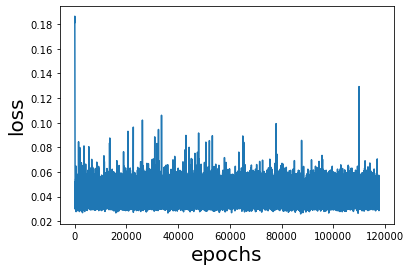

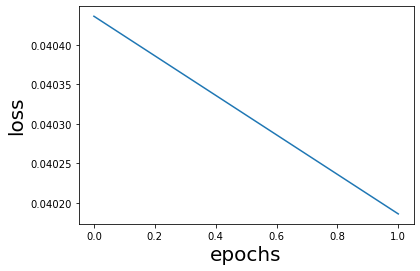

In [35]:
print('total epochs', model.epochs)
plot_loss(loss_train)
plot_loss(model.losses)

## Evaluate

In [ ]:
answer_len = 10
while(1):
    question = input("Question: ") 
    if question == 'quit':
        break
    #answer_len = input("Maximum Reply Length: ")
    #question = remove_punc(question.strip()).split()[:max_len - 1]
    #question = encode_question(question, word_map, max_len)
    #question = torch.LongTensor(question).to(device).unsqueeze(0)
    question = get_data_from_line(question, word_length, char_to_num)
    question = torch.Tensor(question).to(device).unsqueeze(0)
    reply = evaluate(model, question, answer_len)
    sentence = data_to_line(reply, num_to_char)
    print(sentence)

Question:  Where


where kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb 


Question:  no


no kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb 


Question:  hi


hi kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb kjfb 


In [53]:
question.shape

torch.Size([1, 1, 16])

# Works

In [283]:
texts = glob.glob(my_path + 'parts/*.txt')

In [284]:
char_to_num, num_to_char = create_char_dict()

In [299]:
word_length = 16
seq_length = 32
batch_size = 64
layers = [1, 8, 16, 32]
d_emb = 256
dropout = 0

In [38]:
file_name = random.choice(texts)
data = get_data_from_file(file_name, word_length, char_to_num)

In [39]:
data.shape

(1976683, 16)

In [76]:
#data_len = len(data) - batch_size - seq_length
batch = 0
x = []
y_input = []
y_target = []
for word in range(batch_size):
    start_ind = batch + word
    middle_ind = start_ind + seq_length
    end_ind = middle_ind + seq_length
    x.append(data[start_ind : middle_ind])
    y_input.append(data[middle_ind - 1 : end_ind - 1])
    y_target.append(data[middle_ind : end_ind])

In [77]:
x = torch.as_tensor(x)#.to(device)
y_input = torch.as_tensor(y_input)#.to(device)
y_target = torch.as_tensor(y_target)#.to(device)

In [78]:
x.shape

torch.Size([64, 32, 16])

In [81]:
embedd = Embedder(word_length, emb_layers, d_emb, 0, seq_length)

In [82]:
line = 'hi how'
ques = get_data_from_line(line, word_length, char_to_num)
ques = torch.Tensor(ques).unsqueeze(0)

In [83]:
ques.shape

torch.Size([1, 2, 16])

In [84]:
x_out = embedd(ques.float())

torch.Size([2, 1, 16])
torch.Size([2, 32, 16])


In [85]:
x_out.shape

torch.Size([1, 2, 256])

In [ ]:
model.eval()
with torch.no_grad():
    encoded = model.encode(question)
    reply = [question[:, -1, :]]# + [word_map['<pad>']] * 31]
    reply = torch.Tensor(reply).to(device)
    for step in range(3):
        dims = reply.size(-1)
        reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
        reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = model.decode(encoded, reply)
        #print(decoded.shape)
        predictions = model.out(decoded[:, -1])
        out = model.out_1(decoded)
        out = F.relu(out)
        out = model.out_2(out)
        out = F.sigmoid(out)
        out = out.item()

        reply = torch.cat([reply, torch.Tensor([[out]]).to(device)], dim = 1) 


In [79]:
x_out = embedd(x.float())

torch.Size([2048, 1, 16])
torch.Size([2048, 32, 16])


In [308]:
x_out.shape

torch.Size([64, 32, 256])

torch.Size([1, 2, 16])

 Costa            Rica             and              Qater            each             made             their            debut            in               the              event.           The              United           States           appeared         for              the              26th             time,            most             of               any              nation,          having           missed           only             the              boycotted        1980             Games.           Summary.         The              hammer          


In [214]:
class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        embeds = self.embeddings(x).view(1,-1)
        output = self.linear1(embeds)
        output = F.relu(output)
        output = self.linear2(output)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [215]:
set_dropout(model, 0)

In [56]:
voc_s = 100
smooth = 0.1
confidence = 1 - smooth
criterion = nn.KLDivLoss(reduction = 'none')

In [ ]:
prediction = torch.rand(128, 32, voc_s)
target = torch.randint(10, (128, 32))
prediction = rearrange(prediction, 'i j k -> (i j) k')
target = rearrange(target, 'i j -> (i j)')
labels = torch.full(prediction.shape, smooth / (voc_s - 1))



# mask = mask.float()
# mask = mask.view(-1)       # (batch_size * max_words)
labels.scatter_(1, target.data.unsqueeze(1), self.confidence)

In [58]:
prediction = torch.rand(128, 32, voc_s)
type(prediction)

torch.Tensor

In [357]:
target = torch.randint(10, (128, 32))
target.shape

torch.Size([128, 32])

In [358]:
prediction = rearrange(prediction, 'i j k -> (i j) k')
prediction.shape

torch.Size([4096, 100])

In [359]:
target = rearrange(target, 'i j -> (i j)')
target.shape

torch.Size([4096])

In [360]:
labels = torch.full(prediction.shape, smooth / (voc_s - 1))
labels.shape

torch.Size([4096, 100])

In [361]:
labels.scatter_(1, target.unsqueeze(1), confidence)

tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.9000, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]])

In [371]:
loss = criterion(prediction, labels)

In [375]:
loss.sum(1)

tensor([-1.3567, -1.2366, -1.6016,  ..., -1.2049, -1.7134, -1.6225])

In [328]:
X_len

tensor([4, 1, 5, 3])

In [181]:
mask = torch.arange(maxlen)[None, :] < X_len[:, None]
mask

tensor([[ True,  True,  True,  True, False],
        [ True, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, False, False]])

In [180]:
X_len[:, None]

tensor([[4],
        [1],
        [6],
        [3]])

In [182]:
X[~mask] = float('-inf')
X

tensor([[4.6000, 4.4000, 3.4000, 4.2000,   -inf],
        [4.4000,   -inf,   -inf,   -inf,   -inf],
        [3.2000, 4.2000, 5.0000, 4.0000, 3.6000],
        [3.6000, 3.4000, 4.2000,   -inf,   -inf]], dtype=torch.float64)

In [42]:
query = [1, 2]
key = [2, 4]
value = [3, 5]

In [113]:
torch.arange(0, 8, 2)

tensor([0, 2, 4, 6])

In [122]:
np.random.permutation([2, 5])

array([2, 5])

In [39]:
tens1 = torch.rand(2, 3, 4, 4)
tens2 = torch.randint(10, (4, 2, 3))

In [40]:
tens1

tensor([[[[0.7623, 0.8450, 0.3682, 0.6576],
          [0.9663, 0.5621, 0.8374, 0.5769],
          [0.4835, 0.0790, 0.6344, 0.3626],
          [0.4561, 0.6238, 0.3120, 0.8371]],

         [[0.8442, 0.6722, 0.8046, 0.3118],
          [0.2308, 0.3600, 0.2550, 0.9474],
          [0.5318, 0.6913, 0.8854, 0.1981],
          [0.0054, 0.0419, 0.0806, 0.0649]],

         [[0.8957, 0.9161, 0.2589, 0.9291],
          [0.7460, 0.7448, 0.5106, 0.8558],
          [0.8403, 0.6256, 0.7644, 0.7588],
          [0.9533, 0.5586, 0.2438, 0.8019]]],


        [[[0.7899, 0.5312, 0.0525, 0.2539],
          [0.3274, 0.7521, 0.6769, 0.0284],
          [0.4078, 0.1044, 0.9185, 0.6738],
          [0.5765, 0.8693, 0.8912, 0.5624]],

         [[0.3052, 0.7401, 0.5834, 0.4826],
          [0.7597, 0.4807, 0.9562, 0.4233],
          [0.3731, 0.7180, 0.8609, 0.5208],
          [0.4574, 0.6568, 0.1493, 0.1426]],

         [[0.9422, 0.5193, 0.8503, 0.7638],
          [0.5910, 0.5961, 0.5622, 0.4374],
          [0.4099, 0

In [41]:
d = tens1.size(-1)
d

4

In [42]:
inds = torch.triu_indices(d, d, offset = 1)

In [43]:
tens1[..., inds[0], inds[1]] = -float('inf')

In [44]:
tens1

tensor([[[[0.7623,   -inf,   -inf,   -inf],
          [0.9663, 0.5621,   -inf,   -inf],
          [0.4835, 0.0790, 0.6344,   -inf],
          [0.4561, 0.6238, 0.3120, 0.8371]],

         [[0.8442,   -inf,   -inf,   -inf],
          [0.2308, 0.3600,   -inf,   -inf],
          [0.5318, 0.6913, 0.8854,   -inf],
          [0.0054, 0.0419, 0.0806, 0.0649]],

         [[0.8957,   -inf,   -inf,   -inf],
          [0.7460, 0.7448,   -inf,   -inf],
          [0.8403, 0.6256, 0.7644,   -inf],
          [0.9533, 0.5586, 0.2438, 0.8019]]],


        [[[0.7899,   -inf,   -inf,   -inf],
          [0.3274, 0.7521,   -inf,   -inf],
          [0.4078, 0.1044, 0.9185,   -inf],
          [0.5765, 0.8693, 0.8912, 0.5624]],

         [[0.3052,   -inf,   -inf,   -inf],
          [0.7597, 0.4807,   -inf,   -inf],
          [0.3731, 0.7180, 0.8609,   -inf],
          [0.4574, 0.6568, 0.1493, 0.1426]],

         [[0.9422,   -inf,   -inf,   -inf],
          [0.5910, 0.5961,   -inf,   -inf],
          [0.4099, 0

In [ ]:
torch.einsum('...td,...id->...ti', tens1, tens2)

In [ ]:
rearrange(tens2, '... i j -> ... (i j)')

In [30]:
tens1.size(-1)

4

In [23]:
torch.triu_indices(5, 5, offset = 1)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
        [0, 1, 2, 3, 4, 1, 2, 3, 4, 2, 3, 4, 3, 4, 4]])

(4, 5, 3, 2)

In [37]:
tempo = torch.einsum('...ij->...ji', tens2)
tempo

tensor([[[7, 4],
         [6, 8],
         [6, 9]],

        [[6, 4],
         [5, 5],
         [3, 5]],

        [[4, 7],
         [1, 7],
         [3, 2]],

        [[3, 9],
         [5, 9],
         [6, 2]]])

In [39]:
torch.einsum('...ij,...jk->...ik', tens1, tempo)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

In [40]:
torch.einsum('...ij,...kj->...ik', tens1, tens2)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

In [84]:
arr = np.random.randint(1, 10, (2, 3, 4))

In [85]:
arr

array([[[9, 7, 2, 8],
        [3, 1, 9, 1],
        [1, 2, 4, 2]],

       [[8, 3, 4, 9],
        [8, 8, 7, 6],
        [7, 2, 4, 2]]])

In [89]:
arr.min(axis = (0,2))

array([2, 1, 1])

In [8]:
dr = 0

In [5]:
if dr:
    dr = 5
else:
    dr = None
print(dr)

5


In [9]:
dr = 4 if dr else None
print(dr)

None
